## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [10]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [11]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


None

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [12]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
display(data.groupby(['group']).min(), data.groupby(['group']).max() )


,user_id,date,purchase,price
group,,,,
A,630002,2021-01-02,0,0
B,630000,2021-01-02,0,0


,user_id,date,purchase,price
group,,,,
A,945998,2021-01-24,1,200000
B,945999,2021-01-24,1,200000


In [9]:
display(data.groupby(['group']).min(), data.groupby(['group']).max() )

,user_id,date,purchase,price
group,,,,
A,630002,2021-01-02,0,0
B,630000,2021-01-02,0,0


,user_id,date,purchase,price
group,,,,
A,945998,2021-01-24,1,200000
B,945999,2021-01-24,1,200000


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [34]:
group_agg = data.groupby(['group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
display(group_agg.head())

print('Количество посещений сайта в группах А и B:')
display(data.groupby('group')['user_id'].agg('count'))
print('\nКоличество покупок в группах А и B:')
display(data.groupby('group')['purchase'].agg('sum'))
print('\nСумма покупок в группах А и B:')
display(data.groupby('group')['price'].agg('sum') / 1e6)

,group,count_visits,count_purchases,sum_price
0,A,147202,17723,1436260000
1,B,147276,17514,1554100000


Количество посещений сайта в группах А и B:


group
A    147202
B    147276
Name: user_id, dtype: int64


Количество покупок в группах А и B:


group
A    17723
B    17514
Name: purchase, dtype: int64


Сумма покупок в группах А и B:


group
A    1436.26
B    1554.10
Name: price, dtype: float64

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [22]:
user_set_a = set(data[data['group'] == 'A']['user_id'])
user_set_b = set(data[data['group'] == 'B']['user_id'])
user_intersection = user_set_a.intersection(user_set_b)

print(len(user_intersection))

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [23]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

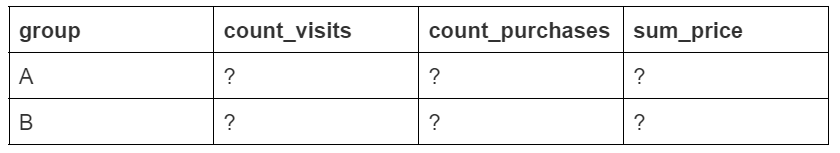
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [29]:
group_agg = updated_data.groupby(['group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
display(group_agg.head())

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

## Вывод1
Количество посещений обоих вариантов посадочной странице сопостовимо и сбалансировано, разница всего лишь 0,05%.

Используя калькулятор для подсчета необходимого числа тестов https://www.evanmiller.org/ab-testing/sample-size.html показывает что нужно 76,979 тестов, при конверсии 12% , 5% эффекте и 5% значимости альфа.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [33]:
group_agg['conversion'] = group_agg['count_purchases'] / group_agg['count_visits'] *100
group_agg['mean_check'] = group_agg['sum_price'] / group_agg['count_purchases']

display(group_agg.head())
print('Конверсия (в процентах) в группах А и B:')
display(group_agg['conversion'].round(2))
print('\nСредний чек (в рублях) в группах А и B:')
display(group_agg['mean_check'].round())

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


Конверсия (в процентах) в группах А и B:


0    12.03
1    11.89
Name: conversion, dtype: float64


Средний чек (в рублях) в группах А и B:


0    81076.0
1    88665.0
Name: mean_check, dtype: float64

Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

## Вывод2
вариант А эффективнее варианта B по показателю конверсии, в тоже время вариант В эффективнее варианта А по показателю "средний чек"

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [40]:
data_pivot = updated_data[updated_data['price'] > 0].pivot_table(
    index='group', 
    columns='price', 
    values='purchase', 
    aggfunc='sum'
)


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

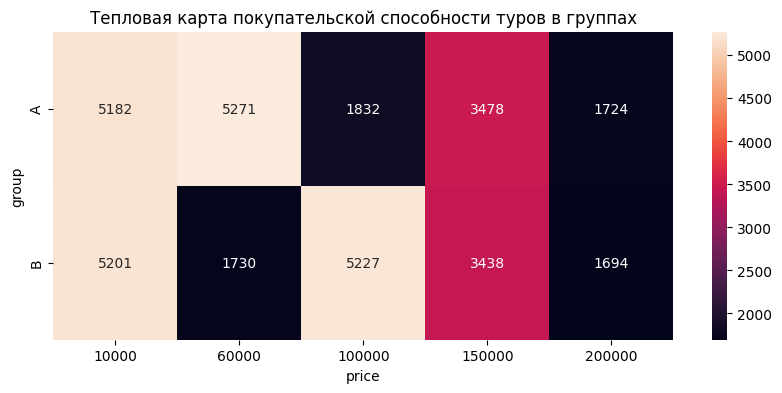

In [41]:
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(data_pivot, fmt='.0f', annot=True);
ax.set_title('Тепловая карта покупательской способности туров в группах');

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

## Вывод3
 покупательская способность участников группы А выше, чем участников группы B в турах 60К, 150К и 200К. У группы B выше в турах 10К и 100К.


## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [51]:
dayily_group = updated_data.groupby(['date', 'group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
dayily_group['conversion'] = dayily_group['count_purchases'] / dayily_group['count_visits'] *100
dayily_group['mean_check'] = dayily_group['sum_price'] / dayily_group['count_purchases']

#display(dayily_group.head())

print('Конверсия (в процентах)  3 января 2021 года в группах А и B:')
display(dayily_group[dayily_group['date'] == '2021-01-03']['conversion'].round(2))
print('\nСредний чек (в рублях)  3 января 2021 года в группах А и B:')
display(dayily_group[dayily_group['date'] == '2021-01-03']['mean_check'].round())

Конверсия (в процентах)  3 января 2021 года в группах А и B:


2    11.34
3    11.39
Name: conversion, dtype: float64


Средний чек (в рублях)  3 января 2021 года в группах А и B:


2    82888.0
3    87480.0
Name: mean_check, dtype: float64

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [71]:
dayily_group['cum_users_count'] = dayily_group.groupby('group')['count_visits'].cumsum()
dayily_group['cum_purchase'] = dayily_group.groupby('group')['count_purchases'].cumsum()
dayily_group['cum_price'] = dayily_group.groupby('group')['sum_price'].cumsum()

dayily_group['cum_conversion'] = dayily_group['cum_purchase']/dayily_group['cum_users_count'] * 100
dayily_group['cum_mean_check'] = dayily_group['cum_price']/dayily_group['cum_purchase']


#display(dayily_group.head())
print('Конверсия (в процентах) в группе B на 20 января: ')
display(dayily_group[(dayily_group['date'] == '2021-01-20')]['cum_conversion'].round(2))
print('\nСредний чек (в рублях) в группе А на 12 января 2021 года:')
display(dayily_group[dayily_group['date'] == '2021-01-12']['cum_mean_check'].round())

Конверсия (в процентах) в группе B на 20 января: 


36    11.98
37    11.90
Name: cum_conversion, dtype: float64


Средний чек (в рублях) в группе А на 12 января 2021 года:


20    81492.0
21    88352.0
Name: cum_mean_check, dtype: float64

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

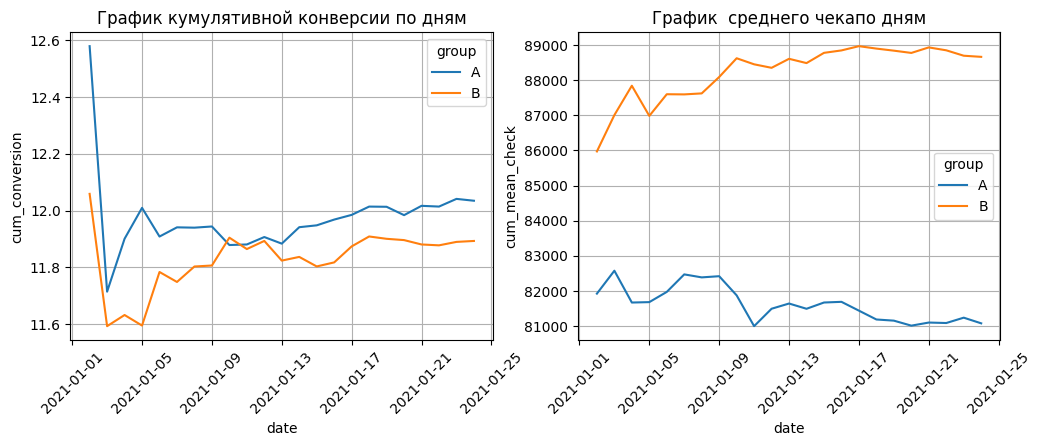

In [70]:
# создаём фигуру размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=dayily_group, hue='group', ax=axes[0])
# строим lineplot для  среднего чека во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=dayily_group, hue='group', ax=axes[1])
# задаём подпись к графику
axes[0].set_title('График кумулятивной конверсии по дням')
axes[1].set_title('График  среднего чекапо дням')
# задаём поворот меток на оси абсцисс
axes[0].xaxis.set_tick_params(rotation = 45)
axes[1].xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
axes[0].grid(True);
axes[1].grid(True);

## Вывод4

 A/B-тест можно  назвать завершённым, потому что обе метрики стабилизировались во времени 

 Как соотносятся кумулятивные показатели в каждой группе :  
 
 По конверсии группа А показывает более высокие значения начиная с момента стабилизации с 11.01.2021, и после стабилизации обе группы изменяются в одну сторону.

По среднему чеку группа В показывает стабильно более высокие значения. Также с 11.01.2021 наблюдается стабилизация метрики.


## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [73]:
converted_piv= updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv)

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'

alpha = 0.05 # уровень значимости

# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger'
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 

,sum,count
group,,
A,17487,145307
B,17290,145381


p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

## Вывод5

статистическая разница между конверсиями в группах А и B отсутствует, так как p-value не упало ниже уровнем значимости 5%.
необходим дополнительный анализ, можно построить доверительный интервал и убедиться.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [76]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 -gamma
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)


#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']

#
##Доверительный интервал для конверсии в группах:
#
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

#
##Доверительный интервал для разницы конверсии в группах:
#
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('\nДоверительный интервал для разности конверсий: {}'.format(diff_inverval))


Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

## Вывод6

Присутствует перекрытие между доверительными интервалами для групп, это значит что статистически обе выборки не отличиму по признаку конверсии.
Также статистическая разница содержит 0 в своем интервале, что также указывает на то что нет статистической разницы между конверсиями в группах А и B

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [87]:
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05

_, p = shapiro(dayily_group[dayily_group['group'] == 'A']['mean_check'])

# выводим результат на экран
print('p-value для группы А: ', round(p, 2))
# сравниваем полученное p-value с уровнем значимости
if (p < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(Ha))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
    
 
_, p = shapiro(dayily_group[dayily_group['group'] == 'B']['mean_check'])
 
# выводим результат на экран
print('p-value  для группы В: ', round(p, 2))
# сравниваем полученное p-value с уровнем значимости
if (p < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(Ha))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value для группы А:  0.25
Принимаем нулевую гипотезу. Данные распределены нормально
p-value  для группы В:  0.09
Принимаем нулевую гипотезу. Данные распределены нормально


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [95]:
H0 = 'равенство ежедневных средних чеков'
Ha = 'ежедневный средний чек в А меньше, чем в группе B'
alpha = 0.05

#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=dayily_group[dayily_group['group'] == 'A']['mean_check'],
    b=dayily_group[dayily_group['group'] == 'B']['mean_check'], 
    alternative='less'
)
print('p-value:', results.pvalue)
#print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(Ha))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 


p-value: 1.1261794674808954e-12
Отвергаем нулевую гипотезу. равенство ежедневных средних чеков
Альтернативная гипотеза. H1: ежедневный средний чек в А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

## Вывод7

Присутствует статистическая разница между ежедневными средними чеками в группах А и B, значение p-value очень мало и существенно ниже уровня значимости в 5%, что дает нам достаточные основания отвергнуть нулевую гипотезу о равенстве средних чеков и принять альтернативную гипотезу о том что средний чек в группе В больше. 

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [98]:
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t критическое
    eps = t_crit * x_std / n**0.5 #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound), round(upper_bound)
 
params_a = {
    'n': dayily_group[dayily_group['group'] == 'A']['count_visits'].count(), # размер выборки
    'x_mean': dayily_group[dayily_group['group'] == 'A']['mean_check'].mean(), # выборочное средние
    'x_std': dayily_group[dayily_group['group'] == 'A']['mean_check'].std() # выборочное стандартное отклонения
}
params_b = {
    'n': dayily_group[dayily_group['group'] == 'B']['count_visits'].count(),# размер выборки
    'x_mean': dayily_group[dayily_group['group'] == 'B']['mean_check'].mean(), # выборочное средние
    'x_std': dayily_group[dayily_group['group'] == 'B']['mean_check'].std() # выборочное стандартное отклонения
}
 
print('Доверительный интервал для среднего чека группы А: {}'.format(mean_check_conf_interval(**params_a))) 
print('Доверительный интервал для среднего чека группы B: {}'.format(mean_check_conf_interval(**params_b)))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

## Вывод8

В доверительные интервалы для ежедневных средних чеков в группах отсутствует пересечение, это значит что отличия в выборка по этой метрике являются статистически значимыми и показывают что средний чек в группе действительно выше. 


## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

При том что конверсия в обоих группах осталась статистически одинаковой, средний чек в группе В существенно выше чем в группе А, что является хорошим показателем улучшения продаж и является более эффективным вариантом по комбинации обоих метрик.

С другой стороны если посмотреть на распределение продаж по турам, то группа А показывает большее покрытие, 3 из 5 туров, тогда как группа В только 2 из 5. При выборе варианта В возможен сильный перекос в только в сторону определенных направлений, который необходимо учесть. 